In [250]:
# Lessons
# 1. Damiani uses a different normalization. They do not divide by the scale parameter when computing the CWT. Need to account for this
# if you are using their results

In [251]:
import numpy as np
import sys, os
import _maps as maps
import _wavelets as wt

import healpy as hp
import astropy_healpix

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import norm, uniform
from scipy.integrate import quad

from tqdm import tqdm

(-1.0, 1.0)

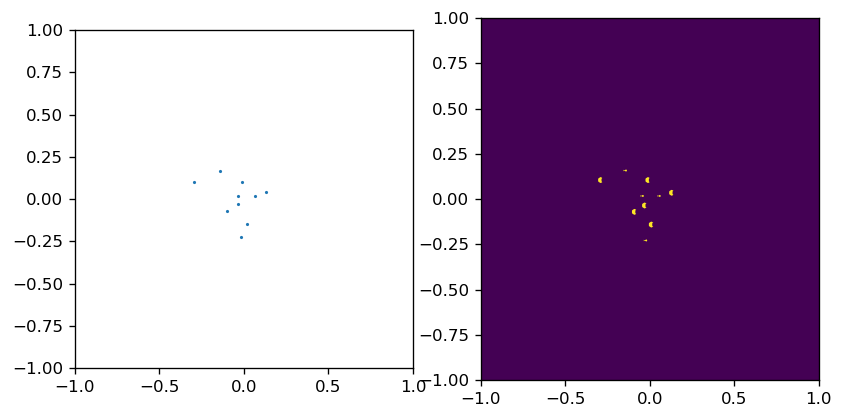

In [252]:
nm = norm(scale = 0.1, loc = 0)
x_data = nm.rvs(size = 10)
y_data = nm.rvs(size = 10)

fig = plt.figure(figsize=(8, 4), dpi= 120)
ax = fig.add_subplot(121)
ax.set_aspect('equal')

ax.scatter(x_data, y_data, s = 0.8)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

ax = fig.add_subplot(122)
ax.hexbin(x_data,y_data, gridsize = 100, extent = [-1,1,-1,1])
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

(-1.0, 1.0)

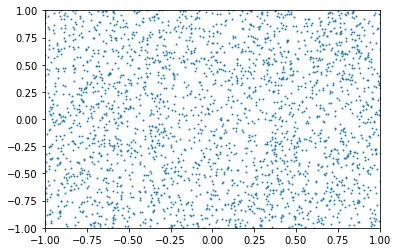

In [253]:
# "uniform distribution"

N_data = 10000

uni = uniform(loc = -2, scale = 4)
N_uni = N_data
x_uni = uni.rvs(size = int(N_uni))
y_uni = uni.rvs(size = int(N_uni))

x_data = np.concatenate((x_data, x_uni))
y_data = np.concatenate((y_data, y_uni))

plt.scatter(x_uni, y_uni, s = 0.8)
plt.xlim([-1,1])
plt.ylim([-1,1])

In [254]:
bx_min, bx_max, by_min, by_max = [-1, 1,
                                  -1, 1]

scale = 0.05
step_size = scale 
mesh_bxby, arr_b, arr_bx_plot, arr_by_plot = maps.build_mesh_(bx_min, bx_max, by_min, by_max, step_size, step_size, return_arrays_for_plotting=True)
arr_bx = 0.5*(arr_bx_plot[1:] + arr_bx_plot[:-1])
arr_by = 0.5*(arr_by_plot[1:] + arr_by_plot[:-1])

(-1.0, 1.0)

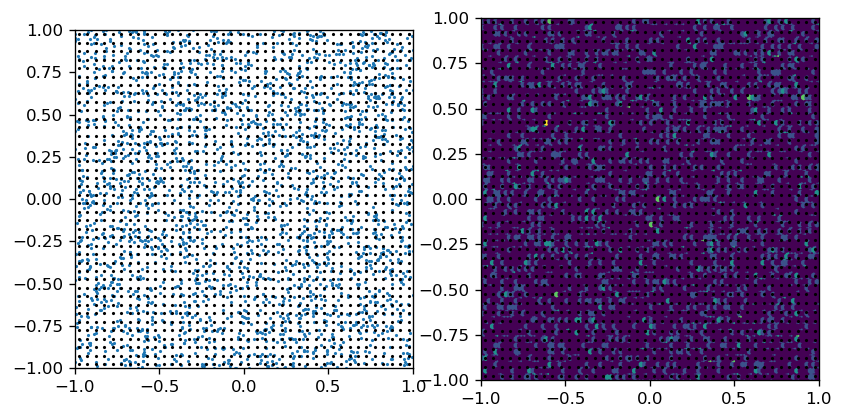

In [255]:
fig = plt.figure(figsize=(8, 4), dpi= 120)
ax = fig.add_subplot(121)
ax.set_aspect('equal')

ax.scatter(x_data, y_data, s = 0.8)
ax.scatter(arr_b[:,0], arr_b[:,1], s = 0.8, c = 'k')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

ax = fig.add_subplot(122)
ax.hexbin(x_data,y_data, gridsize = 100, extent = [-1,1,-1,1])
ax.scatter(arr_b[:,0], arr_b[:,1], s = 0.8, c = 'k')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

In [256]:
# copy/paste from skysearch/generate_wavelet_coefficients.py

# load scale parameter
a = np.sqrt(3) * 0.1
arr_a = np.array([a])
Na = len(arr_a)

# define 2d wavelet
wavelet_name = 'mexh'
mexh = wt._2d_wavelet(wavelet_name)

# pre-allocate wavelet coefficient map 
data = np.stack([x_data, y_data], axis = -1)
N_data, N_dim = data.shape
Ny, Nx = mesh_bxby.shape[:-1]
cwt_map = np.zeros((Ny, Nx, 1))

# broadcast arrays in wavelet calculation
buf_data = data[np.newaxis,np.newaxis,np.newaxis]
buf_mesh_bxby = mesh_bxby[:,:,np.newaxis,np.newaxis,np.newaxis]
buf_arr_a = arr_a[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

# calculate arguments of wavelet coefficients
# buf_grid = grid[:,:,np.newaxis,np.newaxis,np.newaxis]
buf_arr_arg =  ( (buf_data - buf_mesh_bxby ) / buf_arr_a )

# calculate wavelet coefficients
buf_mexh_output = mexh.base_fct(buf_arr_arg)

# remove two dimensions of a-array to divide mexh
buf_arr_a_sq = np.squeeze(buf_arr_a, axis = -1)
buf_arr_a_sq = np.squeeze(buf_arr_a_sq, axis = -1)

# estimate wavelet coefficient by summing over datapoints
buf_cwt_map = np.sum(buf_mexh_output, axis = -1) / buf_arr_a_sq 
buf_cwt_map = np.squeeze(buf_cwt_map, axis = -1)

# copy wavelet coefficient map to output array
cwt_map[:,:,0] = buf_cwt_map[:,:,0] 

In [257]:
def wt_gaussian_(bx,by,a,sigma,N_data):
    r_sq = bx**2. + by**2.
    return (N_data / (1 + sigma**2. / a**2.)**2. ) * (2 - (r_sq / (a**2. + sigma**2.) ) ) * np.exp( - (r_sq) / (2. * (a**2. + sigma**2.)) ) / a

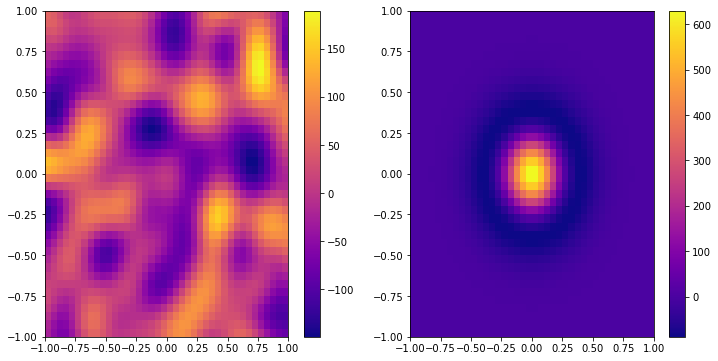

In [258]:
# compare to Gaussian 

# evaluate norm pdf at each grid point
output_pdf = np.zeros((len(arr_bx), len(arr_by)))
for nx in range(len(arr_bx)):
    for ny in range(len(arr_by)):
        output_pdf[nx,ny] = wt_gaussian_(arr_bx[nx], arr_by[ny], a, 0.1, 100) 

fig = plt.figure(1,figsize=(12,6))
ax = fig.add_subplot(121)

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='plasma', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=np.min(cwt_map[:,:,0]), 
                                                 vmax=np.max(cwt_map[:,:,0])))
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.colorbar(plot)

ax = fig.add_subplot(122)
plot2 = ax.pcolormesh(arr_bx_plot, arr_by_plot, output_pdf, cmap='plasma', shading='flat')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.colorbar(plot2)

In [259]:
print(np.max(cwt_map[:,:,0]))
print(8/9 * np.max(cwt_map[:,:,0] * a))

print(np.max(output_pdf[:,:]))
print(8/9 * np.max(output_pdf[:,:]) * a)

189.73395962061616
29.211454043033683
629.4577996413627
96.91136801772006
